#    Lecture #20: More Clustering

Calculating distance between two feature vectors: 
     
        Minkovsky Metric:
        
        d(X1,X2) = (sum.|(x1-x2)|^p)^1/p    if p = 1 => called Manhattan distance
                                            if p = 2 => called Euclidean distance 

### Hierarchical clustering


In [105]:
#Code shared across examples
import pylab, random, string, copy

class Point(object):
    def __init__(self, name, originalAttrs, normalizedAttrs = None):
        """normalizedAttrs and originalAttrs are both arrays"""
        self.name = name
        self.unNormalized = originalAttrs
        if normalizedAttrs is None:
            self.attrs = originalAttrs
        else:
            self.attrs = normalizedAttrs
    def dimensionality(self):
        return len(self.attrs)
    def getAttrs(self):
        return self.attrs
    def getOriginalAttrs(self):
        return self.unNormalized
    def distance(self, other):
        #Euclidean distance metric
        result = 0.0
        for i in range(self.dimensionality()):
            result += (self.attrs[i] - other.attrs[i])**2
        return result**0.5
    def getName(self):
        return self.name
    def toStr(self):
        return self.name + str(self.attrs)
    def __str__(self):
        return self.name   

In [106]:
class Cluster(object):
    def __init__(self, points, pointType):
        self.points = points
        self.pointType = pointType
        self.centroid = self.computeCentroid()
    def singleLinkageDist(self, other):
        minDist = self.points[0].distance(other.points[0])
        for p1 in self.points:
            for p2 in other.points:
                if p1.distance(p2) < minDist:
                    minDist = p1.distance(p2)
        return minDist
    def maxLinkageDist(self, other):
        maxDist = self.points[0].distance(other.points[0])
        for p1 in self.points:
            for p2 in other.points:
                if p1.distance(p2) > maxDist:
                    maxDist = p1.distance(p2)
        return maxDist
    def averageLinkageDist(self, other):
        totDist = 0.0
        for p1 in self.points:
            for p2 in other.points:
                totDist += p1.distance(p2)
        return totDist/(len(self.points)*len(other.points))
    def update(self, points):
        oldCentroid = self.centroid
        self.points = points
        if len(points) > 0:
            self.centroid = self.computeCentroid()
            return oldCentroid.distance(self.centroid)
        else:
            return 0.0
    def members(self):
        for p in self.points:
            yield p
    def isIn(self, name):
        for p in self.points:
            if p.getName() == name:
                return True
        return False
    def toStr(self):
        result = ''
        for p in self.points:
            result = result + p.toStr() + ', '
        return result[:-2]
    def __str__(self):
        names = []
        for p in self.points:
            names.append(p.getName())
        names.sort()
        result = ''
        for p in names:
            result = result + p + ', '
        return result[:-2]
    def getCentroid(self):
        return self.centroid
    def computeCentroid(self):
        dim = self.points[0].dimensionality()
        totVals = pylab.array([0.0]*dim)
        for p in self.points:
            totVals += p.getAttrs()
        centroid = self.pointType('mean',
                                   totVals/float(len(self.points)),
                                   totVals/float(len(self.points)))
        return centroid

In [107]:
class ClusterSet(object):
    def __init__(self, pointType):
        self.members = []
    def add(self, c):
        if c in self.members:
            raise ValueError
        self.members.append(c)
    def getClusters(self):
        return self.members[:]
    def mergeClusters(self, c1, c2):
        points = []
        for p in c1.members():
            points.append(p)
        for p in c2.members():
            points.append(p)
        newC = Cluster(points, type(p))
        self.members.remove(c1)
        self.members.remove(c2)
        self.add(newC)
        return c1, c2
    def findClosest(self, metric):
        minDistance = metric(self.members[0], self.members[1])
        toMerge = (self.members[0], self.members[1])
        for c1 in self.members:
            for c2 in self.members:
                if c1 == c2:
                    continue
                if metric(c1, c2) < minDistance:
                    minDistance = metric(c1, c2)
                    toMerge = (c1, c2)
        return toMerge    
    def mergeOne(self, metric, toPrint = False):
        if len(self.members) == 1:
            return None
        if len(self.members) == 2:
            return self.mergeClusters(self.members[0],
                                      self.members[1])
        toMerge = self.findClosest(metric)
        if toPrint:
            print ('Merged')
            print ('  ' + str(toMerge[0]))
            print ('with')
            print ('  ' + str(toMerge[1]))
        self.mergeClusters(toMerge[0], toMerge[1])
        return toMerge
    def mergeN(self, metric, numClusters = 1, history = [],
               toPrint = False):
        assert numClusters >= 1
        while len(self.members) > numClusters:
            merged = self.mergeOne(metric, toPrint)
            history.append(merged)
        return history
    def numClusters(self):
        return len(self.members) + 1
    def __str__(self):
        result = ''
        for c in self.members:
            result = result + str(c) + '\n'
        return result

#Mammal's teeth example
class Mammal(Point):
    def __init__(self, name, originalAttrs, scaledAttrs = None):
        Point.__init__(self, name, originalAttrs, originalAttrs)
    def scaleFeatures(self, key): 
        scaleDict = {'identity': [1,1,1,1,1,1,1,1],
                     '1/max': [1/3.0,1/4.0,1.0,1.0,1/4.0,1/4.0,1/6.0,1/6.0]}
        scaledFeatures = []
        features = self.getOriginalAttrs()
        for i in range(len(features)):
            scaledFeatures.append(features[i]*scaleDict[key][i])
        self.attrs = scaledFeatures
        
def readMammalData(fName):
    dataFile = open(fName, 'r')
    teethList = []
    nameList = []
    for line in dataFile:
        if len(line) == 0 or line[0] == '#':
            continue
        dataLine = str.split(line)
        teeth = dataLine.pop(-1)
        features = []
        for t in teeth:
            features.append(float(t))
        name = ''
        for w in dataLine:
            name = name + w + ' '
        name = name[:-1]
        teethList.append(features)
        nameList.append(name)
    return nameList, teethList
    
def buildMammalPoints(fName, scaling):
    nameList, featureList = readMammalData(fName)
    points = []
    for i in range(len(nameList)):
        point = Mammal(nameList[i], pylab.array(featureList[i]))
        point.scaleFeatures(scaling)
        points.append(point)
    return points

In [108]:
#Use hierarchical clustering for mammals teeth
def test0(numClusters = 2, scaling = 'identity', printSteps = False,
          printHistory = True):
    points = buildMammalPoints('mammalTeeth.txt', scaling)
    cS = ClusterSet(Mammal)
    for p in points:
        cS.add(Cluster([p], Mammal))
    history = cS.mergeN(Cluster.maxLinkageDist, numClusters,
                        toPrint = printSteps)
    if printHistory:
        print ('')
        for i in range(len(history)):
            names1 = []
            for p in history[i][0].members():
                names1.append(p.getName())
            names2 = []
            for p in history[i][1].members():
                names2.append(p.getName())
            print ('Step', i, 'Merged', names1, 'with', names2)
            print ('')
    clusters = cS.getClusters()
    print ('Final set of clusters:')
    index = 0
    for c in clusters:
        print('  C' + str(index) + ':', c)
        index += 1

In [109]:
test0()


Step 0 Merged ['Beaver'] with ['Groundhog']

Step 1 Merged ['Gray Squirrel'] with ['Porcupine']

Step 2 Merged ['Wolf'] with ['Bear']

Step 3 Merged ['Marten'] with ['Wolverine']

Step 4 Merged ['Weasel'] with ['Badger']

Step 5 Merged ['Jaguar'] with ['Cougar']

Step 6 Merged ['Fur Seal'] with ['Sea Lion']

Step 7 Merged ['Reindeer'] with ['Elk']

Step 8 Merged ['Deer'] with ['Moose']

Step 9 Merged ['Dog'] with ['Wolf', 'Bear']

Step 10 Merged ['Brown Bat'] with ['Silver Hair Bat']

Step 11 Merged ['Pigmy Bat'] with ['House Bat']

Step 12 Merged ['Pika'] with ['Rabbit']

Step 13 Merged ['River Otter'] with ['Marten', 'Wolverine']

Step 14 Merged ['Sea Otter'] with ['Grey Seal']

Step 15 Merged ['Beaver', 'Groundhog'] with ['Gray Squirrel', 'Porcupine']

Step 16 Merged ['Reindeer', 'Elk'] with ['Deer', 'Moose']

Step 17 Merged ['Red Bat'] with ['Human']

Step 18 Merged ['Raccoon'] with ['Dog', 'Wolf', 'Bear']

Step 19 Merged ['Elephant Seal'] with ['Fur Seal', 'Sea Lion']

Step 20 Me

In [110]:
test0(scaling='1/max')


Step 0 Merged ['Beaver'] with ['Groundhog']

Step 1 Merged ['Gray Squirrel'] with ['Porcupine']

Step 2 Merged ['Wolf'] with ['Bear']

Step 3 Merged ['Marten'] with ['Wolverine']

Step 4 Merged ['Weasel'] with ['Badger']

Step 5 Merged ['Jaguar'] with ['Cougar']

Step 6 Merged ['Fur Seal'] with ['Sea Lion']

Step 7 Merged ['Reindeer'] with ['Elk']

Step 8 Merged ['Deer'] with ['Moose']

Step 9 Merged ['Dog'] with ['Wolf', 'Bear']

Step 10 Merged ['Brown Bat'] with ['Silver Hair Bat']

Step 11 Merged ['Pigmy Bat'] with ['House Bat']

Step 12 Merged ['Pika'] with ['Rabbit']

Step 13 Merged ['River Otter'] with ['Marten', 'Wolverine']

Step 14 Merged ['Sea Otter'] with ['Grey Seal']

Step 15 Merged ['Beaver', 'Groundhog'] with ['Gray Squirrel', 'Porcupine']

Step 16 Merged ['Reindeer', 'Elk'] with ['Deer', 'Moose']

Step 17 Merged ['Red Bat'] with ['Human']

Step 18 Merged ['Raccoon'] with ['Dog', 'Wolf', 'Bear']

Step 19 Merged ['Elephant Seal'] with ['Fur Seal', 'Sea Lion']

Step 20 Me

In [111]:
#US Counties example
class County(Point):
    #Interesting subsets of features
    #0=don't use, 1=use
    noWealth = (('HomeVal', '0'), ('Income', '0'), ('Poverty', '0'),
                    ('Population', '1'), ('Pop Change', '1'),
                    ('Prcnt 65+', '1'), ('Below 18', '1'),
                    ('Prcnt Female', '1'), ('Prcent HS Grad', '1'),
                    ('Prcnt College', '1'), ('Unemployed', '0'),
                    ('Prcent Below 18', '1'), ('Life Expect', '1'),
                    ('Farm Acres', '1'))
    wealthOnly = (('HomeVal', '1'), ('Income', '1'), ('Poverty', '1'),
                    ('Population', '0'), ('Pop Change', '0'),
                    ('Prcnt 65+', '0'), ('Below 18', '0'),
                    ('Prcnt Female', '0'), ('Prcent HS Grad', '0'),
                    ('Prcnt College', '0'), ('Unemployed', '1'),
                    ('Prcent Below 18', '0'), ('Life Expect', '0'),
                    ('Farm Acres', '0'))
    education = (('HomeVal', '0'), ('Income', '0'), ('Poverty', '0'),
                    ('Population', '0'), ('Pop Change', '0'),
                    ('Prcnt 65+', '0'), ('Below 18', '0'),
                    ('Prcnt Female', '0'), ('Prcent HS Grad', '1'),
                    ('Prcnt College', '1'), ('Unemployed', '0'),
                    ('Prcent Below 18', '0'), ('Life Expect', '0'),
                    ('Farm Acres', '0'))
    noEducation = (('HomeVal', '1'), ('Income', '0'), ('Poverty', '1'),
                    ('Population', '1'), ('Pop Change', '1'),
                    ('Prcnt 65+', '1'), ('Below 18', '1'),
                    ('Prcnt Female', '1'), ('Prcent HS Grad', '1'),
                    ('Prcnt College', '0'), ('Unemployed', '0'),
                    ('Prcent Below 18', '1'), ('Life Expect', '1'),
                    ('Farm Acres', '1'))
    allFeatures = (('HomeVal', '1'), ('Income', '0'), ('Poverty', '1'),
                    ('Population', '1'), ('Pop Change', '1'),
                    ('Prcnt 65+', '1'), ('Below 18', '1'),
                    ('Prcnt Female', '1'), ('Prcent HS Grad', '1'),
                    ('Prcnt College', '1'), ('Unemployed', '1'),
                    ('Prcent Below 18', '1'), ('Life Expect', '1'),
                    ('Farm Acres', '1'))
    filterNames = {'all': allFeatures, 'education': education,
                   'noEducation': noEducation,
                   'wealthOnly': wealthOnly,'noWealth': noWealth}
    attrFilter = None
    #Override Point to construct subset of features
    def __init__(self, name, originalAttrs, normalizedAttrs = None,
                 filterName = 'all'):
        if County.attrFilter == None:
            County.attrFilter = ''
            filterSpec = County.filterNames[filterName]
            for f in filterSpec:
                County.attrFilter += f[1]
        Point.__init__(self, name, originalAttrs, normalizedAttrs)
        features = []
        for i in range(len(County.attrFilter)):
            if County.attrFilter[i] == '1':
                features.append((self.getAttrs()[i]))
        self.features = features 
    #Override Point.distance to use only subset of features
    def distance(self, other):
        result = 0.0
        for i in range(len(self.features)):
            result += (self.features[i] - other.features[i])**2
        return result**0.5

def readCountyData(fName, numEntries = 14):
    dataFile = open(fName, 'r')
    dataList = []
    nameList = []
    maxVals = pylab.array([0.0]*numEntries)
    #Build unnormalized feature vector
    for line in dataFile:
        if len(line) == 0 or line[0] == '#':
            continue
        dataLine = str.split(line)
        name = dataLine[0] + dataLine[1]
        features = []
        #Build vector with numEntries features
        for f in dataLine[2:]:
            try:
                f = float(f)
                features.append(f)
                if f > maxVals[len(features)-1]:
                    maxVals[len(features)-1] = f
            except ValueError:
                name = name + f
        if len(features) != numEntries:
            continue
        dataList.append(features)
        nameList.append(name)
    return nameList, dataList, maxVals
    
def buildCountyPoints(fName, filterName = 'all', scale = True):
    nameList, featureList, maxVals = readCountyData(fName)
    points = []
    for i in range(len(nameList)):
        originalAttrs = pylab.array(featureList[i])
        if scale:
            normalizedAttrs = originalAttrs/pylab.array(maxVals)
        else:
            normalizedAttrs = originalAttrs
        points.append(County(nameList[i], originalAttrs,
                             normalizedAttrs, filterName))
    return points

def getAveIncome(cluster):
    tot = 0.0
    numElems = 0
    for c in cluster.members():
        tot += c.getOriginalAttrs()[1]
        numElems += 1
    if numElems > 0:
        return tot/numElems
    return 0.0

In [112]:
#Use hierarchical clustering for counties
#It will run for a VERY long time
def test3(fileName, scale = False, filterName = 'all',
          printSteps = False, printHistory = False):
    points = buildCountyPoints(fileName, filterName = filterName,
                               scale = scale)
    cS = ClusterSet(County)
    for p in points:
        cS.add(Cluster([p], County))
    history = cS.mergeN(Cluster.maxLinkageDist, 2, toPrint = printSteps)
    if printHistory:
        print ('')
        for i in range(len(history)):
            names1 = []
            for p in history[i][0].members():
                names1.append(p.getName())
            names2 = []
            for p in history[i][1].members():
                names2.append(p.getName())
            print ('Step', i, 'Merged', names1, 'with', names2)
            print ('')
    clusters = cS.getClusters()
    print ('')
    print ('Final set of clusters:')
    index = 0
    for c in clusters:
        print ('  C' + str(index) + ':', c)
        index += 1

In [113]:
# test3('counties.txt')   - WILL TAKE FOREVER!!!

In [114]:
test3('newEngland.txt')


Final set of clusters:
  C0: MAMiddlesex
  C1: CTFairfield, CTHartford, CTLitchfield, CTMiddlesex, CTNewHaven, CTNewLondon, CTTolland, CTWindham, MABarnstable, MABerkshire, MABristol, MADukes, MAEssex, MAFranklin, MAHampden, MAHampshire, MANantucket, MANorfolk, MAPlymouth, MASuffolk, MAWorcester, MEAndroscoggin, MEAroostook, MECumberland, MEFranklin, MEHancock, MEKennebec, MEKnox, MELincoln, MEOxford, MEPenobscot, MEPiscataquis, MESagadahoc, MESomerset, MEWaldo, MEWashington, MEYork, RIBristol, RIKent, RINewport, RIProvidence, RIWashington, VTAddison, VTBennington, VTCaledonia, VTChittenden, VTEssex, VTFranklin, VTGrandIsle, VTLamoille, VTOrange, VTOrleans, VTRutland, VTWashington, VTWindham, VTWindsor


MAMiddlesex county has 600k more people than any other county - swamped everything else - we need to scale!!

In [115]:
test3('newEngland.txt', scale=True)


Final set of clusters:
  C0: CTFairfield, CTHartford, CTNewHaven, MABristol, MAEssex, MAHampden, MAMiddlesex, MANorfolk, MAPlymouth, MASuffolk, MAWorcester, RIProvidence
  C1: CTLitchfield, CTMiddlesex, CTNewLondon, CTTolland, CTWindham, MABarnstable, MABerkshire, MADukes, MAFranklin, MAHampshire, MANantucket, MEAndroscoggin, MEAroostook, MECumberland, MEFranklin, MEHancock, MEKennebec, MEKnox, MELincoln, MEOxford, MEPenobscot, MEPiscataquis, MESagadahoc, MESomerset, MEWaldo, MEWashington, MEYork, RIBristol, RIKent, RINewport, RIWashington, VTAddison, VTBennington, VTCaledonia, VTChittenden, VTEssex, VTFranklin, VTGrandIsle, VTLamoille, VTOrange, VTOrleans, VTRutland, VTWashington, VTWindham, VTWindsor


#    Lecture # 21: Using Graphs to Model Problems, Part 1

### K-Means clustering:
    1) Choose K
    2) Choose K points as initial centroid (often chosen at random)
    3) Assign each point to the nearest centroid
    4) Choose new centroid for each cluster
    5) Assign each point to nearest centroid => new clustering
    6) Repeat 4 and 5 untill the change is small
    

In [116]:
def kmeans(points, k, cutoff, pointType, maxIters = 100,
           toPrint = False):
    #Get k randomly chosen initial centroids
    initialCentroids = random.sample(points, k)
    clusters = []
    #Create a singleton cluster for each centroid
    for p in initialCentroids:
        clusters.append(Cluster([p], pointType))
    numIters = 0
    biggestChange = cutoff
    while biggestChange >= cutoff and numIters < maxIters:
        #Create a list containing k empty lists
        newClusters = []
        for i in range(k):
            newClusters.append([])
        for p in points:
            #Find the centroid closest to p
            smallestDistance = p.distance(clusters[0].getCentroid())
            index = 0
            for i in range(k):
                distance = p.distance(clusters[i].getCentroid())
                if distance < smallestDistance:
                    smallestDistance = distance
                    index = i
            #Add p to the list of points for the appropriate cluster
            newClusters[index].append(p)
        #Update each cluster and record how much the centroid has changed
        biggestChange = 0.0
        for i in range(len(clusters)):
            change = clusters[i].update(newClusters[i])
            biggestChange = max(biggestChange, change)
        numIters += 1
    #Calculate the coherence of the least coherent cluster
    maxDist = 0.0
    for c in clusters:
        for p in c.members():
            if p.distance(c.getCentroid()) > maxDist:
                maxDist = p.distance(c.getCentroid())
    print ('Number of iterations =', numIters, 'Max Diameter =', maxDist)
    return clusters, maxDist

In [117]:
def test1(k = 2, cutoff = 0.0001, numTrials = 1, printSteps = False,
          printHistory = False):
    points = buildMammalPoints('mammalTeeth.txt', '1/max')
    if printSteps:
        print ('Points:')
        for p in points:
            attrs = p.getOriginalAttrs()
            for i in range(len(attrs)):
                attrs[i] = round(attrs[i], 2)
            print ('  ', p, attrs)
    numClusterings = 0
    bestDiameter = None
    while numClusterings < numTrials:
        clusters, maxDiameter = kmeans(points, k, cutoff, Mammal)
        if bestDiameter == None or maxDiameter < bestDiameter:
            bestDiameter = maxDiameter
            bestClustering = copy.deepcopy(clusters)
        if printHistory:
            print ('Clusters:')
            for i in range(len(clusters)):
                print ('  C' + str(i) + ':', clusters[i])
        numClusterings += 1
    print ('\nBest Clustering')
    for i in range(len(bestClustering)):
        print ('  C' + str(i) + ':', bestClustering[i])

In [118]:
test1()

Number of iterations = 2 Max Diameter = 1.0978813069715374

Best Clustering
  C0: Beaver, Deer, Elk, Gray Squirrel, Groundhog, House Mouse, Moose, Pika, Porcupine, Rabbit, Rat, Reindeer
  C1: Badger, Bear, Brown Bat, Cougar, Dog, Elephant Seal, Fur Seal, Grey Seal, House Bat, Human, Jaguar, Marten, Mole, Pigmy Bat, Raccoon, Red Bat, River Otter, Sea Lion, Sea Otter, Silver Hair Bat, Weasel, Wolf, Wolverine


In [119]:
test1()

Number of iterations = 4 Max Diameter = 1.0978813069715374

Best Clustering
  C0: Beaver, Deer, Elk, Gray Squirrel, Groundhog, House Mouse, Moose, Pika, Porcupine, Rabbit, Rat, Reindeer
  C1: Badger, Bear, Brown Bat, Cougar, Dog, Elephant Seal, Fur Seal, Grey Seal, House Bat, Human, Jaguar, Marten, Mole, Pigmy Bat, Raccoon, Red Bat, River Otter, Sea Lion, Sea Otter, Silver Hair Bat, Weasel, Wolf, Wolverine


In [120]:
test1(printHistory=True)

Number of iterations = 5 Max Diameter = 1.0978813069715374
Clusters:
  C0: Beaver, Deer, Elk, Gray Squirrel, Groundhog, House Mouse, Moose, Pika, Porcupine, Rabbit, Rat, Reindeer
  C1: Badger, Bear, Brown Bat, Cougar, Dog, Elephant Seal, Fur Seal, Grey Seal, House Bat, Human, Jaguar, Marten, Mole, Pigmy Bat, Raccoon, Red Bat, River Otter, Sea Lion, Sea Otter, Silver Hair Bat, Weasel, Wolf, Wolverine

Best Clustering
  C0: Beaver, Deer, Elk, Gray Squirrel, Groundhog, House Mouse, Moose, Pika, Porcupine, Rabbit, Rat, Reindeer
  C1: Badger, Bear, Brown Bat, Cougar, Dog, Elephant Seal, Fur Seal, Grey Seal, House Bat, Human, Jaguar, Marten, Mole, Pigmy Bat, Raccoon, Red Bat, River Otter, Sea Lion, Sea Otter, Silver Hair Bat, Weasel, Wolf, Wolverine


In [121]:
test1(numTrials = 100)
test1(numTrials = 100)

Number of iterations = 5 Max Diameter = 1.0978813069715374
Number of iterations = 2 Max Diameter = 1.0978813069715374
Number of iterations = 2 Max Diameter = 1.2565649826234835
Number of iterations = 3 Max Diameter = 1.2565649826234835
Number of iterations = 4 Max Diameter = 1.0978813069715374
Number of iterations = 4 Max Diameter = 1.0978813069715374
Number of iterations = 4 Max Diameter = 1.2565649826234835
Number of iterations = 5 Max Diameter = 1.0978813069715374
Number of iterations = 2 Max Diameter = 1.2565649826234835
Number of iterations = 5 Max Diameter = 1.0978813069715374
Number of iterations = 2 Max Diameter = 1.0978813069715374
Number of iterations = 5 Max Diameter = 1.0978813069715374
Number of iterations = 5 Max Diameter = 1.0978813069715374
Number of iterations = 4 Max Diameter = 1.0978813069715374
Number of iterations = 5 Max Diameter = 1.0978813069715374
Number of iterations = 3 Max Diameter = 1.0978813069715374
Number of iterations = 5 Max Diameter = 1.09788130697153

Number of iterations = 5 Max Diameter = 1.0978813069715374
Number of iterations = 5 Max Diameter = 1.0978813069715374
Number of iterations = 2 Max Diameter = 1.2565649826234835
Number of iterations = 2 Max Diameter = 1.0978813069715374
Number of iterations = 2 Max Diameter = 1.0978813069715374
Number of iterations = 4 Max Diameter = 1.0978813069715374
Number of iterations = 3 Max Diameter = 1.2565649826234835
Number of iterations = 2 Max Diameter = 1.0978813069715374
Number of iterations = 3 Max Diameter = 1.0978813069715374
Number of iterations = 5 Max Diameter = 1.0978813069715374
Number of iterations = 2 Max Diameter = 1.0978813069715374
Number of iterations = 2 Max Diameter = 1.2565649826234835
Number of iterations = 2 Max Diameter = 1.0978813069715374
Number of iterations = 5 Max Diameter = 1.0978813069715374
Number of iterations = 3 Max Diameter = 1.0978813069715374
Number of iterations = 5 Max Diameter = 1.0978813069715374
Number of iterations = 5 Max Diameter = 1.09788130697153

In [122]:
def test(k = 50, cutoff = 0.01, numTrials = 1, myHome = 'MAMiddlesex',
         filterName = 'all', printPoints = False,
         printClusters = True):
    #Build the set of points
    points = buildCountyPoints('counties.txt', filterName)
    if printPoints:
        print ('Points')
        for p in points:
            attrs = p.getAttrs()
            for i in range(len(attrs)):
                attrs[i] = round(attrs[i], 2)
            print ('  ', p, attrs)
    numClusterings = 0
    bestDistance = None
    #Run k-means multiple times and choose best
    while numClusterings < numTrials:
        print ('Starting clustering number', numClusterings)
        clusters, maxSmallest = kmeans(points, k, cutoff, County)
        numClusterings += 1
        if bestDistance == None or maxSmallest < bestDistance:
            bestDistance = maxSmallest
            bestClustering = copy.deepcopy(clusters)
        if printClusters:
            print ('Clusters:')
        for i in range(len(clusters)):
            if printClusters:
                print ('  C' + str(i) + ':', clusters[i])
    for c in bestClustering:
        incomes = []
        for i in range(len(bestClustering)):
            incomes.append(getAveIncome(bestClustering[i]))
            if printClusters:
                print ('  C' + str(i) + ':', bestClustering[i])
        pylab.hist(incomes)
        pylab.xlabel('Ave. Income')
        pylab.ylabel('Number of Clusters')
        if c.isIn(myHome):
            print ('\nHome Cluster:', c)
            print ('Ave. income =', round(getAveIncome(c),0))

In [123]:
##test(k = 5, filterName = 'all', printClusters = False)
##pylab.title('All Features')
##pylab.figure()
##test(k = 5, filterName = 'wealthOnly', printClusters = False)
##pylab.title('Home Value, Income, Unemployed')
##pylab.figure()
##test(k = 50, filterName = 'education', numTrials = 5, printClusters = False)
##pylab.title('Education Level')
##pylab.show()
##test(k = 50, filterName = 'all', numTrials = 2, printClusters = False)
##pylab.title('All Features')
##pylab.figure()
##test(k = 50, filterName = 'noEducation', numTrials = 2, printClusters = False)
##pylab.title('All - Education')
##pylab.show()

Cluster on education level only
Starting clustering number 0
Number of iterations = 16 Max Diameter = 1.653257987010357
Starting clustering number 1
Number of iterations = 17 Max Diameter = 1.1541672015453257

Home Cluster: CAAlameda, CAMarin, CASanFrancisco, CASanMateo, CASantaClara, CASantaCruz, COBoulder, COGunnison, COPitkin, CTFairfield, GAFulton, IAJohnson, ILDuPage, MADukes, MAMiddlesex, MANorfolk, MDMontgomery, MIOakland, MIWashtenaw, MNHennepin, NCOrange, NJBergen, NJMorris, NJSomerset, NYNassau, NYNewYork, NYRockland, NYWestchester, ORBenton, RINewport, VAAlbemarle, VAFairfax, VTChittenden, WAKing, WASanJuan, WIDane, WYTeton
Ave. income = 31444.0


Text(0.5, 1.0, 'Education Level')

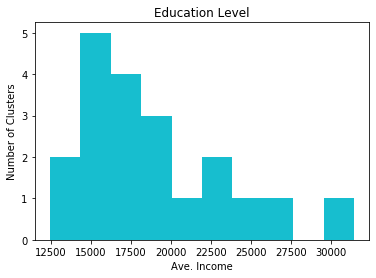

In [124]:
print ('Cluster on education level only')        
test(k = 20, filterName = 'education', numTrials = 2, printClusters = False)
pylab.title('Education Level')  

Cluster on education level only
Starting clustering number 0
Number of iterations = 15 Max Diameter = 1.1541672015453257
Starting clustering number 1
Number of iterations = 19 Max Diameter = 1.129405899882567
Starting clustering number 2
Number of iterations = 27 Max Diameter = 1.1541672015453257
Starting clustering number 3
Number of iterations = 15 Max Diameter = 1.1541672015453257
Starting clustering number 4
Number of iterations = 20 Max Diameter = 1.1541672015453257

Home Cluster: CAAlameda, CAMarin, CASanFrancisco, CASanMateo, CASantaClara, CASantaCruz, COBoulder, COPitkin, COSummit, CTFairfield, ILDuPage, MADukes, MAMiddlesex, MANantucket, MANorfolk, MDMontgomery, MIWashtenaw, NCOrange, NJMorris, NJSomerset, NYNewYork, NYWestchester, VAAlbemarle, VAFairfax, WAKing, WASanJuan, WYTeton
Ave. income = 33240.0


Text(0.5, 1.0, 'Education Level')

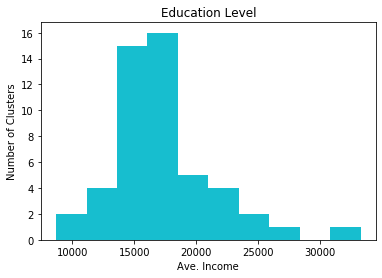

In [125]:
print ('Cluster on education level only')        
test(k = 50, filterName = 'education', numTrials = 5, printClusters = False)
pylab.title('Education Level')  

Cluster on gender only
Starting clustering number 0
Number of iterations = 23 Max Diameter = 1.129405899882567
Starting clustering number 1
Number of iterations = 16 Max Diameter = 1.1541672015453257
Starting clustering number 2
Number of iterations = 13 Max Diameter = 1.1541672015453257
Starting clustering number 3
Number of iterations = 18 Max Diameter = 1.1541672015453257
Starting clustering number 4
Number of iterations = 24 Max Diameter = 1.1541672015453257

Home Cluster: CAAlameda, CAMarin, CASanFrancisco, CASanMateo, CASantaClara, CASantaCruz, COBoulder, COPitkin, COSummit, CTFairfield, ILDuPage, MADukes, MAMiddlesex, MANantucket, MANorfolk, MDMontgomery, MIWashtenaw, NCOrange, NJBergen, NJMorris, NJSomerset, NYNewYork, NYWestchester, VAAlbemarle, VAFairfax, WAKing, WASanJuan, WYTeton
Ave. income = 33254.0


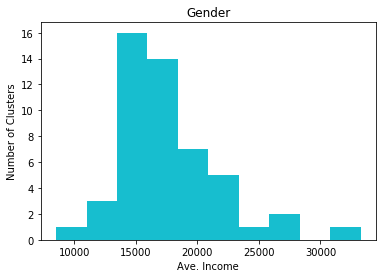

In [126]:
pylab.figure()
print ('Cluster on gender only')
test(k = 50, filterName = 'gender', numTrials = 5, printClusters = False)
pylab.title('Gender')
pylab.show()

### Supervised learning: 
    1) training set with lables
    2) infer relationship between feature and lables

### Unsupervised learning:
    1) training set is all unlablled data
    2) try to infer relationship among points
    
- Be wary of overfitting
- Feautures matter:
    1) which
    2) normolazied
    3) weight

## Graph theoretic

Graph = Set of Nodes (or vertices) connected by a set of edges (arches)

- digraph - if edges unidirectional
- edges can have weights

In [127]:
class Node(object):
    def __init__(self, name):
        self.name = name
    def getName(self):
        return self.name
    def __str__(self):
        return self.name

class Edge(object):
    def __init__(self, src, dest, weight = 0):
        self.src = src
        self.dest = dest
        self.weight = weight
    def getSource(self):
        return self.src
    def getDestination(self):
        return self.dest
    def getWeight(self):
        return self.weight
    def __str__(self):
        return str(self.src) + '->' + str(self.dest)

class Digraph(object):
    def __init__(self):
        self.nodes = set([])
        self.edges = {}
    def addNode(self, node):
        if node.getName() in self.nodes:
            raise ValueError('Duplicate node')
        else:
            self.nodes.add(node)
            self.edges[node] = []
    def addEdge(self, edge):
        src = edge.getSource()
        dest = edge.getDestination()
        if not(src in self.nodes and dest in self.nodes):
            raise ValueError('Node not in graph')
        self.edges[src].append(dest)
    def childrenOf(self, node):
        return self.edges[node]
    def hasNode(self, node):
        return node in self.nodes
    def __str__(self):
        res = ''
        for k in self.edges:
            for d in self.edges[k]:
                res = res + str(k) + '->' + str(d) + '\n'
        return res[:-1]

class Graph(Digraph):
    def addEdge(self, edge):
        Digraph.addEdge(self, edge)
        rev = Edge(edge.getDestination(), edge.getSource())
        Digraph.addEdge(self, rev)

Representation of connections:

- Adjecency matrix N X N
- Adjecency List

# Lecture 22: Using Graphs to Model Problems, Part 2

In [128]:
import random

def test1(kind):
    nodes = []
    for name in range(10):
        nodes.append(Node(str(name)))
    g = kind()
    for n in nodes:
        g.addNode(n)
    g.addEdge(Edge(nodes[0],nodes[1]))
    g.addEdge(Edge(nodes[1],nodes[2]))
    g.addEdge(Edge(nodes[2],nodes[3]))
    g.addEdge(Edge(nodes[3],nodes[4]))
    g.addEdge(Edge(nodes[3],nodes[5]))
    g.addEdge(Edge(nodes[0],nodes[2]))
    g.addEdge(Edge(nodes[1],nodes[1]))
    g.addEdge(Edge(nodes[1],nodes[0]))
    g.addEdge(Edge(nodes[4],nodes[0]))
    print ('The graph:')
    print (g)

In [129]:
test1(Digraph)

The graph:
0->1
0->2
1->2
1->1
1->0
2->3
3->4
3->5
4->0


In [130]:
test1(Graph)

The graph:
0->1
0->2
0->1
0->4
1->0
1->2
1->1
1->1
1->0
2->1
2->3
2->0
3->2
3->4
3->5
4->3
4->0
5->3


- shortest path problem
- shortest weight problem (small total weight) - GOOGLE map problem
- cliques: find a set of nodes such that there exists a path connecting each nodes in the set 
- minimum cut problem (mincut): given a graph and two sets of nodes, you wanna find the minimum number of edges such that if thosee edges are removed => the two sets of edges are disconnected

Question 1: does there exist a node such that has TB and is connected to every node with TB

Question 2: Facebook friends: six-degrees of separation problem => shortest path problem

- recursive depth first search algorithm (DFS): 
    1) recursion ends when start == end
    2) recursive part starts by choosing one child of the node you are currently at and it ends when either you reach a node that has no children, OR the node you are trying to get to, OR it reaches a node it has already seen (ie "visited) - avoid cycles
        - if eneded up with no children and it's not the node it was trying to get to => backtrack to where you were last at
        

In [159]:
def shortestPath(graph, start, end, toPrint = False, visited = []):
    global numCalls
    numCalls += 1
    if toPrint: #for debugging
        print( start, end)
    if not (graph.hasNode(start) and graph.hasNode(end)):
        raise ValueError('Start or end not in graph.')
    path = [str(start)]
    if start == end:
        return path
    shortest = None
    for node in graph.childrenOf(start):
        if (str(node) not in visited): #avoid cycles
            visited = visited + [str(node)] #new list
            newPath = shortestPath(graph, node, end, toPrint, visited)
            if newPath == None:
                continue
            if (shortest == None or len(newPath) < len(shortest)):
                shortest = newPath
    if shortest != None:
        path = path + shortest
    else:
        path = None
    return path

In [134]:
def test2(kind, toPrint = False):
    nodes = []
    for name in range(10):
        nodes.append(Node(str(name)))
    g = kind()
    for n in nodes:
        g.addNode(n)
    g.addEdge(Edge(nodes[0],nodes[1]))
    g.addEdge(Edge(nodes[1],nodes[2]))
    g.addEdge(Edge(nodes[2],nodes[3]))
    g.addEdge(Edge(nodes[3],nodes[4]))
    g.addEdge(Edge(nodes[3],nodes[5]))
    g.addEdge(Edge(nodes[0],nodes[2]))
    g.addEdge(Edge(nodes[1],nodes[1]))
    g.addEdge(Edge(nodes[1],nodes[0]))
    g.addEdge(Edge(nodes[4],nodes[0]))
    print ('The graph:')
    print (g)
    shortest = shortestPath(g, nodes[0], nodes[4], toPrint)
    print ('The shortest path:')
    print (shortest)


In [135]:
test2(Graph)
test2(Digraph)

The graph:
0->1
0->2
0->1
0->4
1->0
1->2
1->1
1->1
1->0
2->1
2->3
2->0
3->2
3->4
3->5
4->3
4->0
5->3
The shortest path:
['0', '4']
The graph:
0->1
0->2
1->2
1->1
1->0
2->3
3->4
3->5
4->0
The shortest path:
['0', '2', '3', '4']


In [143]:
def bigTest1(kind, numNodes = 25, numEdges = 200):
    nodes = []
    for name in range(numNodes):
        nodes.append(Node(str(name)))
    g = kind()
    for n in nodes:
        g.addNode(n)
    for e in range(numEdges):
        src = nodes[random.choice(range(0, len(nodes)))]
        dest = nodes[random.choice(range(0, len(nodes)))]
        g.addEdge(Edge(src, dest))
    print (g)
    print (shortestPath(g, nodes[0], nodes[4]))

In [145]:
bigTest1(Digraph)

0->1
0->4
0->20
0->8
0->1
0->18
0->18
0->5
0->8
1->19
1->22
1->15
1->18
1->3
1->18
2->3
2->0
2->4
2->2
2->24
2->21
3->7
3->13
3->2
3->7
3->15
3->11
4->5
4->23
4->23
4->19
4->9
4->20
4->12
5->11
5->23
5->11
5->10
5->3
5->1
5->21
5->20
5->2
6->14
6->20
6->9
6->1
6->4
6->16
6->20
6->20
7->16
7->6
7->24
7->5
7->7
7->11
7->13
7->3
7->0
7->6
8->12
8->0
8->19
8->23
8->12
8->18
8->4
8->3
9->7
9->23
9->4
9->2
9->21
9->13
9->19
9->1
9->3
10->13
10->0
10->12
10->8
10->13
10->24
10->14
10->5
11->9
11->23
11->13
11->8
11->12
11->3
11->9
12->12
12->7
12->23
12->24
12->10
12->1
12->8
13->18
13->16
13->8
13->9
13->7
13->13
13->9
13->14
13->3
13->1
13->16
13->13
14->19
14->9
14->12
14->12
14->12
14->18
14->11
14->13
14->6
14->15
15->23
15->18
15->3
16->20
16->20
16->3
16->6
16->9
17->4
17->18
17->3
17->9
17->6
17->13
17->18
17->2
17->20
17->13
18->0
18->16
18->20
18->9
18->16
19->5
19->4
19->23
19->6
19->22
19->3
19->9
19->19
19->17
19->14
20->16
20->12
20->21
20->13
20->18
20->14
20->5
20->22
20->7
20

In [146]:
test2(Graph, toPrint = True)

The graph:
0->1
0->2
0->1
0->4
1->0
1->2
1->1
1->1
1->0
2->1
2->3
2->0
3->2
3->4
3->5
4->3
4->0
5->3
0 4
1 4
0 4
2 4
3 4
4 4
5 4
4 4
2 4
3 4
4 4
5 4
2 4
3 4
4 4
5 4
0 4
4 4
4 4
The shortest path:
['0', '4']


#### Memoization - remembering what the answer is and just look it up - table look up
#### => it's at the heart of dynamic programming

In [168]:
def foo(x, lst=[]):
    print(lst)
#     bef = lst
    lst += [x]  # lst.extend(...)
    
    
foo(1)
foo(2)
foo(3)

[]
[1]
[1, 2]


In [174]:
d = {}
d[1, 2] = 3
d[1, 2]

3

In [160]:
def dpShortestPath(graph, start, end, visited = [], memo = {}):
    global numCalls
    numCalls += 1
    if not (graph.hasNode(start) and graph.hasNode(end)):
        raise ValueError('Start or end not in graph.')
    path = [str(start)]
    if start == end:
        return path
    shortest = None
    for node in graph.childrenOf(start):
        if (str(node) not in visited):
            visited = visited + [str(node)]
            try:
                newPath = memo[node, end]
            except:  # should be "except KeyError:" to be more careful
                newPath = dpShortestPath(graph, node, end,
                                         visited, memo)
            if newPath == None:
                continue
            if (shortest == None or len(newPath) < len(shortest)):
                shortest = newPath
                memo[node, end] = newPath
    if shortest != None:
        path = path + shortest
    else:
        path = None
    return path

In [153]:
def test3(kind):
    nodes = []
    for name in range(10):
        nodes.append(Node(str(name)))
    g = kind()
    for n in nodes:
        g.addNode(n)
    g.addEdge(Edge(nodes[0],nodes[1]))
    g.addEdge(Edge(nodes[1],nodes[2]))
    g.addEdge(Edge(nodes[2],nodes[3]))
    g.addEdge(Edge(nodes[3],nodes[4]))
    g.addEdge(Edge(nodes[3],nodes[5]))
    g.addEdge(Edge(nodes[0],nodes[2]))
    g.addEdge(Edge(nodes[1],nodes[1]))
    g.addEdge(Edge(nodes[1],nodes[0]))
    g.addEdge(Edge(nodes[4],nodes[0]))
    print ('The graph:')
    print (g)
    shortest = shortestPath(g, nodes[0], nodes[4])
    print ('The shortest path:')
    print (shortest)
    shortest = dpShortestPath(g, nodes[0], nodes[4])
    print ('The shortest path:')
    print (shortest)
    

In [154]:
test3(Digraph)

The graph:
0->1
0->2
1->2
1->1
1->0
2->3
3->4
3->5
4->0
The shortest path:
['0', '2', '3', '4']
The shortest path:
['0', '2', '3', '4']


Using Dynamics Programming? Problems to use it on must:
    - 1) problem must have an optimal substructure
          => means you can find a globally optimal solutions by combining locally optimal solutions
    - 2) must have overlappin substructure
          => otherwise won't speed up

In [161]:
def bigTest2(kind, numNodes = 25, numEdges = 200):
    global numCalls
    nodes = []
    for name in range(numNodes):
        nodes.append(Node(str(name)))
    g = kind()
    for n in nodes:
        g.addNode(n)
    for e in range(numEdges):
        src = nodes[random.choice(range(0, len(nodes)))]
        dest = nodes[random.choice(range(0, len(nodes)))]
        g.addEdge(Edge(src, dest))
    print (g)
    numCalls = 0
    print (shortestPath(g, nodes[0], nodes[4]))
    print ('Number of calls to shortest path =', numCalls)
    numCalls = 0
    print (dpShortestPath(g, nodes[0], nodes[4]))
    print ('Number of calls to dp shortest path =', numCalls)

bigTest2(Digraph)

0->6
0->14
0->16
0->18
1->11
1->4
1->15
1->3
1->15
1->20
1->15
1->17
1->3
1->2
2->7
2->23
2->12
2->17
2->0
2->19
3->13
3->5
3->24
3->6
3->5
3->15
3->11
3->23
3->4
3->21
3->5
3->22
4->24
4->8
4->1
4->16
4->23
4->8
4->20
4->12
4->10
5->15
5->15
5->13
5->6
5->5
5->0
5->0
5->12
5->13
6->18
6->8
6->14
6->16
6->3
6->19
6->11
6->17
6->11
6->9
6->10
6->21
7->2
7->1
7->12
7->12
7->16
7->15
7->14
7->1
8->24
8->9
8->1
8->1
8->5
8->10
9->5
9->0
9->0
9->8
10->8
10->9
10->17
10->13
10->19
11->11
11->7
11->11
11->3
11->20
12->23
12->11
12->17
12->4
12->10
12->8
12->16
12->22
12->17
12->13
12->16
13->9
13->17
13->23
13->5
13->6
13->8
13->7
13->19
13->2
14->8
14->0
15->12
15->23
15->5
15->3
15->12
15->12
16->14
16->0
16->7
16->2
16->10
16->19
16->1
17->13
17->17
17->20
17->20
17->23
17->15
17->10
17->5
18->3
18->6
18->3
18->20
18->21
18->10
18->7
18->14
18->4
19->3
19->10
19->20
19->14
19->16
19->2
19->5
19->17
19->18
19->11
19->7
19->20
20->20
20->16
20->12
20->2
20->9
20->20
20->19
20->5
20->4
21->9


In [ ]:
class Item(object):
    def __init__(self, n, v, w):
        self.name = n
        self.value = float(v)
        self.weight = float(w)
    def getName(self):
        return self.name
    def getValue(self):
        return self.value
    def getWeight(self):
        return self.weight
    def __str__(self):
        result = '<' + self.name + ', ' + str(self.value) + ', ' + str(self.weight) + '>'
        return result

def buildManyItems(numItems, maxVal, maxWeight):
    Items = []
    for i in range(numItems):
        Items.append(Item(str(i), random.randrange(1, maxVal),
                          random.randrange(1, maxWeight)))
    return Items

def solve(toConsider, avail):
    global numCalls
    numCalls += 1
    if toConsider == [] or avail == 0:
        result = (0, ())
    elif toConsider[0].getWeight() > avail:
        result = solve(toConsider[1:], avail)
    else:
        nextItem = toConsider[0]
        #Explore left branch
        withVal, withToTake = solve(toConsider[1:],
                                      avail - nextItem.getWeight())
        withVal += nextItem.getValue()
        #Explore right branch
        withoutVal, withoutToTake = solve(toConsider[1:], avail)
        #Choose better branch
        if withVal > withoutVal:
            result = (withVal, withToTake + (nextItem,))
        else:
            result = (withoutVal, withoutToTake)
    return result

def smallTest(numItems = 10, maxVal = 20, maxWeight = 15):
    global numCalls
    numCalls = 0
    Items = buildManyItems(numItems, maxVal, maxWeight)
    val, taken = solve(Items, 50)
    for item in taken:
        print(item)
    print 'Total value of items taken = ' + str(val)
    print 'Number of calls = ' + str(numCalls)

##smallTest()
